# Ridge detection 

In [20]:
import zarr
import zarr.storage
import fsspec
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.signal import stft
from scipy.ndimage import uniform_filter1d

In [2]:
# List of shot IDs
shot_ids = [23447, 30005, 30021, 30421]  # Add more as needed

# S3 endpoint
endpoint = "https://s3.echo.stfc.ac.uk"
fs = fsspec.filesystem(
    protocol='simplecache',
    target_protocol="s3",
    target_options=dict(anon=True, endpoint_url=endpoint)
)

In [3]:
store_list = []
zgroup_list = []

In [4]:
# Loop through each shot ID
for shot_id in shot_ids:
    url = f"s3://mast/level2/shots/{shot_id}.zarr"
    
    store = zarr.storage.FSStore(fs=fs, url=url)
    store_list.append(store)
    # open or download the Zarr group
    try:
        zgroup_list.append(zarr.open(store, mode='r'))
        print(f"Loaded shot ID {shot_id}")
        # Do something with zgroup here, like listing arrays:
        # print(list(zgroup.array_keys()))
    except Exception as e:
        print(f"Failed to load shot ID {shot_id}: {e}")

Loaded shot ID 23447
Loaded shot ID 30005
Loaded shot ID 30021
Loaded shot ID 30421


In [5]:
# for store in zgroup:
#     root = zarr.open_group(store, mode='r')
mirnov = [xr.open_zarr(store, group="magnetics") for store in store_list]
mirnov[0]

<xarray.Dataset> Size: 32MB
Dimensions:                                   (b_field_pol_probe_cc_channel: 5,
                                               time_mirnov: 261200,
                                               b_field_pol_probe_ccbv_channel: 40,
                                               time: 2612,
                                               b_field_pol_probe_obr_channel: 18,
                                               b_field_pol_probe_obv_channel: 18,
                                               b_field_pol_probe_omv_channel: 3,
                                               b_field_tor_probe_cc_channel: 3,
                                               b_field_tor_probe_saddle_field_channel: 12,
                                               time_saddle: 26120,
                                               b_field_tor_probe_saddle_voltage_channel: 12,
                                               flux_loop_channel: 15)
Coordinates:
  * b_field_pol_probe_cc_channel              (b_field_pol_probe_cc_channel) <U13 260B ...
  * b_field_pol_probe_ccbv_channel            (b_field_pol_probe_ccbv_channel) <U10 2kB ...
  * b_field_pol_probe_obr_channel             (b_field_pol_probe_obr_channel) <U9 648B ...
  * b_field_pol_probe_obv_channel             (b_field_pol_probe_obv_channel) <U9 648B ...
  * b_field_pol_probe_omv_channel             (b_field_pol_probe_omv_channel) <U11 132B ...
  * b_field_tor_probe_cc_channel              (b_field_tor_probe_cc_channel) <U13 156B ...
  * b_field_tor_probe_saddle_field_channel    (b_field_tor_probe_saddle_field_channel) <U11 528B ...
  * b_field_tor_probe_saddle_voltage_channel  (b_field_tor_probe_saddle_voltage_channel) <U15 720B ...
  * flux_loop_channel                         (flux_loop_channel) <U12 720B '...
  * time                                      (time) float64 21kB -0.099 ... ...
  * time_mirnov                               (time_mirnov) float64 2MB -0.09...
  * time_saddle                               (time_saddle) float64 209kB -0....
Data variables:
    b_field_pol_probe_cc_field                (b_field_pol_probe_cc_channel, time_mirnov) float64 10MB ...
    b_field_pol_probe_ccbv_field              (b_field_pol_probe_ccbv_channel, time) float64 836kB ...
    b_field_pol_probe_obr_field               (b_field_pol_probe_obr_channel, time) float64 376kB ...
    b_field_pol_probe_obv_field               (b_field_pol_probe_obv_channel, time) float64 376kB ...
    b_field_pol_probe_omv_voltage             (b_field_pol_probe_omv_channel, time_mirnov) float64 6MB ...
    b_field_tor_probe_cc_field                (b_field_tor_probe_cc_channel, time_mirnov) float64 6MB ...
    b_field_tor_probe_saddle_field            (b_field_tor_probe_saddle_field_channel, time_saddle) float64 3MB ...
    b_field_tor_probe_saddle_voltage          (b_field_tor_probe_saddle_voltage_channel, time_saddle) float64 3MB ...
    flux_loop_flux                            (flux_loop_channel, time) float64 313kB ...
    ip                                        (time) float64 21kB ...
Attributes:
    description:  
    imas:         magnetics
    label:        Plasma Current
    name:         magnetics
    uda_name:     AMC_PLASMA CURRENT
    units:        A

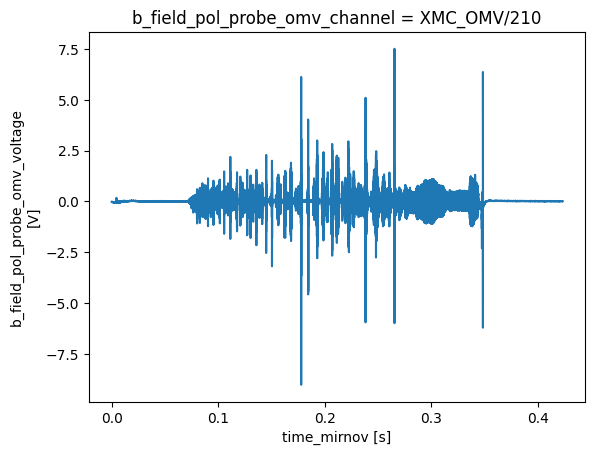

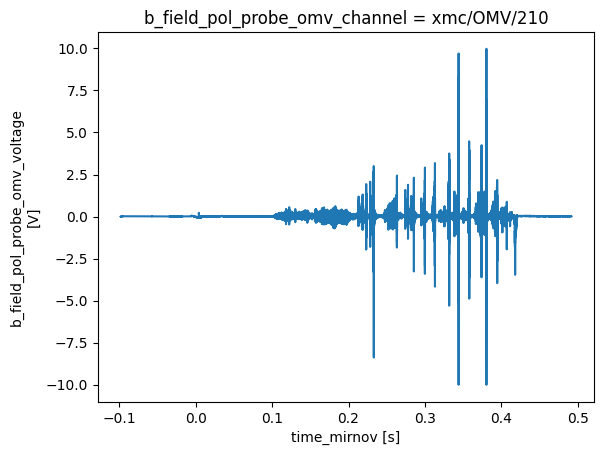

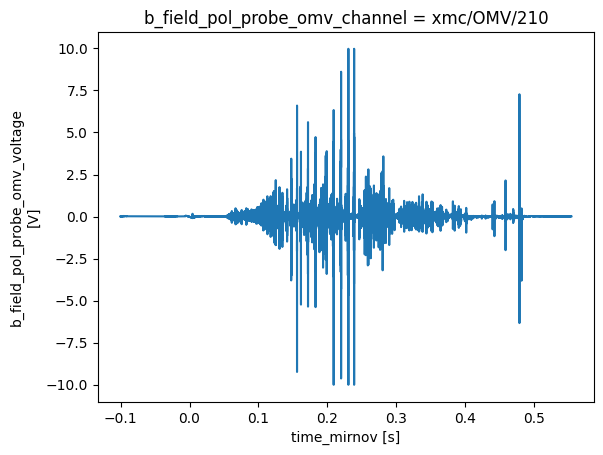

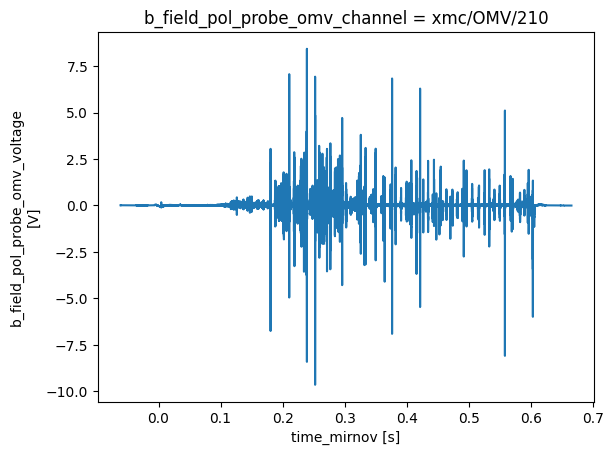

In [6]:
# Extract the DataArrays
ds_list = [m['b_field_pol_probe_omv_voltage'].isel(b_field_pol_probe_omv_channel=1) for m in mirnov]

# Plot all in one figure

for i, ds in enumerate(ds_list):
    plt.figure(i)
    ds.plot(label=f"Shot {i}")

##  Short-Time Fourier Transform (STFT)

In [83]:
def plot_stft_spectrogram(    ds,    shot_id=None,    nperseg=2000,    nfft=2000,    tmin=0.1,    tmax=0.46,    fmax_kHz=50,    cmap='jet'):
    """
    Plot STFT spectrogram for a given xarray DataArray `ds`.
    
    Parameters:
    - ds: xarray.DataArray with a 'time_mirnov' coordinate.
    - shot_id: Optional shot ID for labeling.
    - nperseg: Number of points per STFT segment.
    - nfft: Number of FFT points.
    - tmin, tmax: Time range to display (seconds).
    - fmax_kHz: Max frequency to display (kHz).
    - cmap: Colormap name.
    """
    sample_rate = 1 / float(ds.time_mirnov[1] - ds.time_mirnov[0])
    f, t, Zxx = stft(ds.values, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)

    fig, ax = plt.subplots(figsize=(15, 5))
    cax = ax.pcolormesh(
        t, f / 1000, np.abs(Zxx),
        shading='nearest',
        cmap=plt.get_cmap(cmap, 15),
        norm=LogNorm(vmin=1e-5)
    )
    ax.set_ylim(0, fmax_kHz)
    ax.set_xlim(tmin, tmax)
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [sec]')
    title = f"STFT Spectrogram"
    if shot_id is not None:
        title += f" - Shot {shot_id}"
    ax.set_title(title)
    plt.colorbar(cax, ax=ax, label='Amplitude')
    plt.tight_layout()

[None, None, None, None]

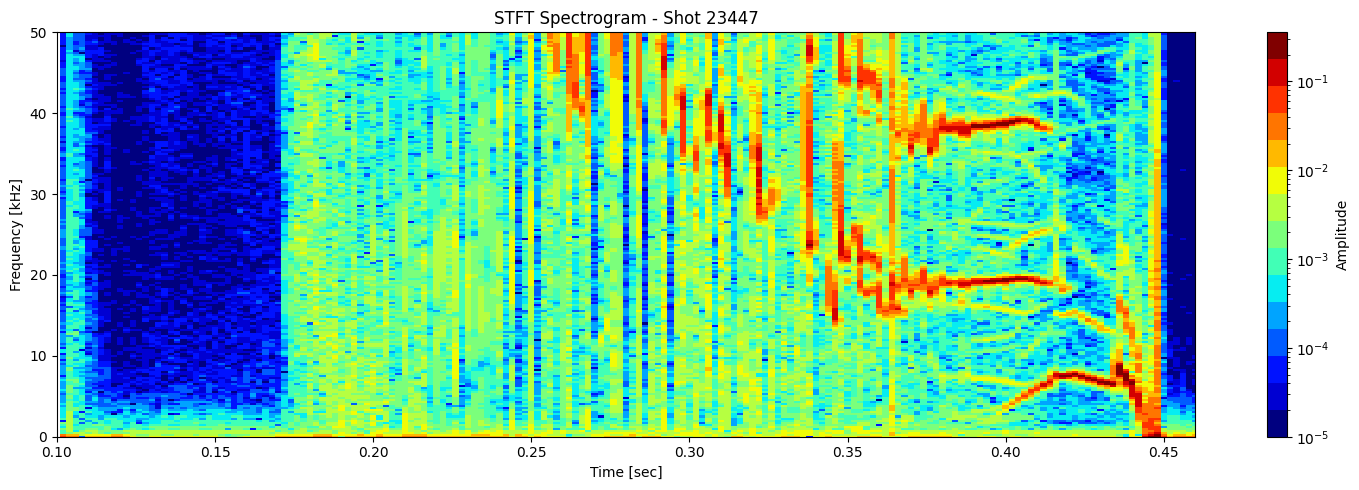

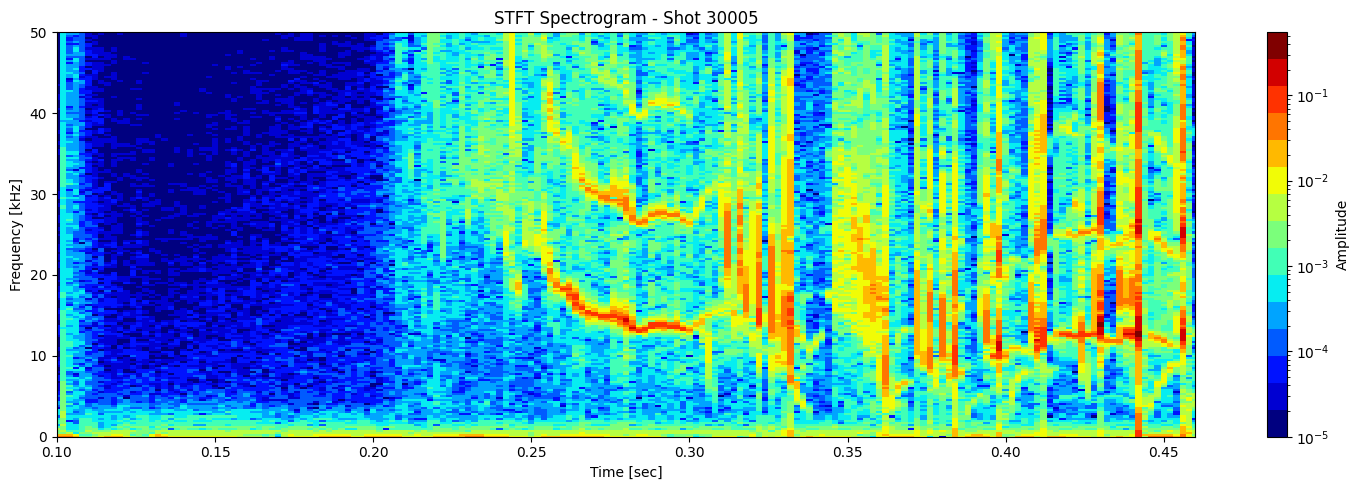

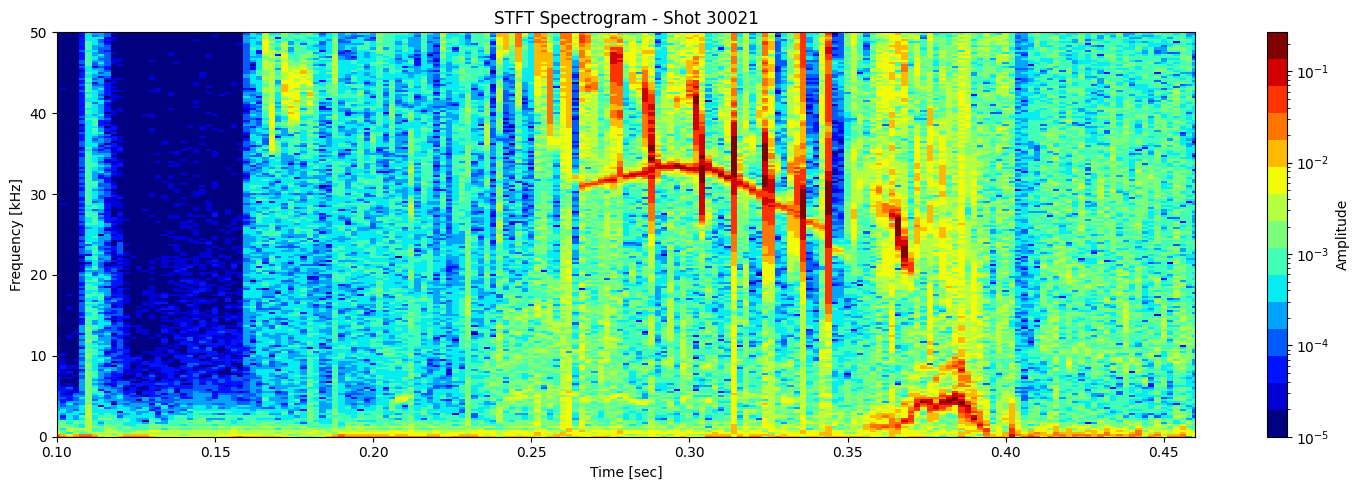

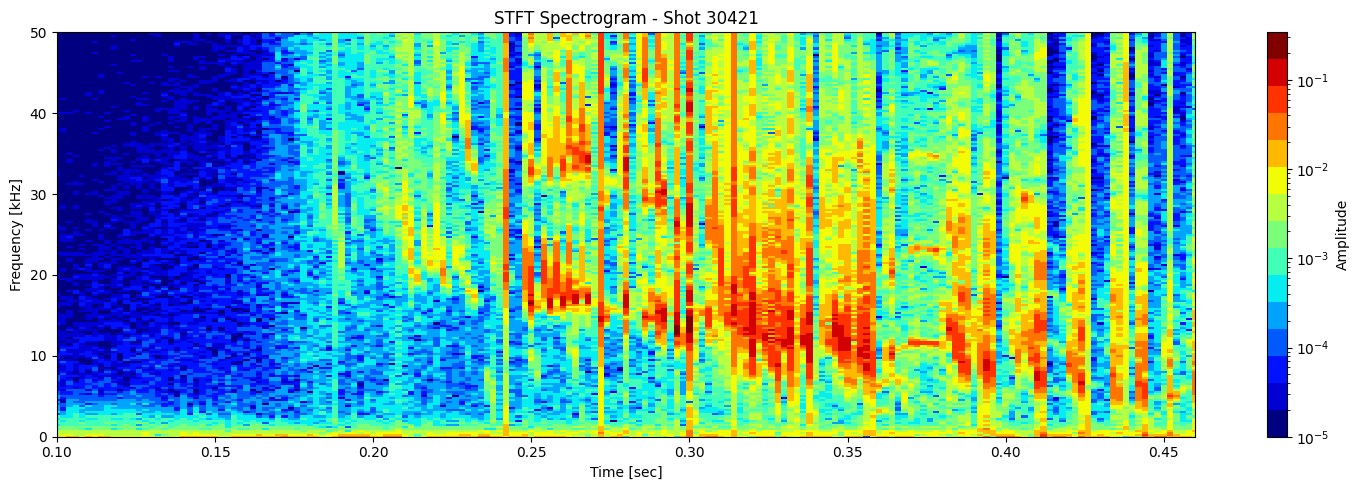

In [84]:
[plot_stft_spectrogram(ds_list[i], shot_ids[i]) for i in range(len(ds_list))]

In [10]:
def plot_stft_histogram(    ds,    shot_id=None,    nperseg=2000,    nfft=2000,    bins=100
):
    """
    Plot a histogram of the absolute STFT amplitude values.

    Parameters:
    - ds: xarray.DataArray with a 'time_mirnov' coordinate.
    - shot_id: Optional shot ID for labeling.
    - nperseg: Number of points per STFT segment.
    - nfft: Number of FFT points.
    - bins: Number of histogram bins.
    """
    sample_rate = 1 / float(ds.time_mirnov[1] - ds.time_mirnov[0])
    f, t, Zxx = stft(ds.values, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)

    plt.figure(figsize=(8, 4))
    plt.hist(np.abs(Zxx.flatten()), bins=bins, log=True)
    plt.xlabel('Amplitude')
    plt.ylabel('Count (log scale)')
    title = 'Histogram of Spectrogram Amplitudes'
    if shot_id is not None:
        title += f" - Shot {shot_id}"
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    return f, t, Zxx

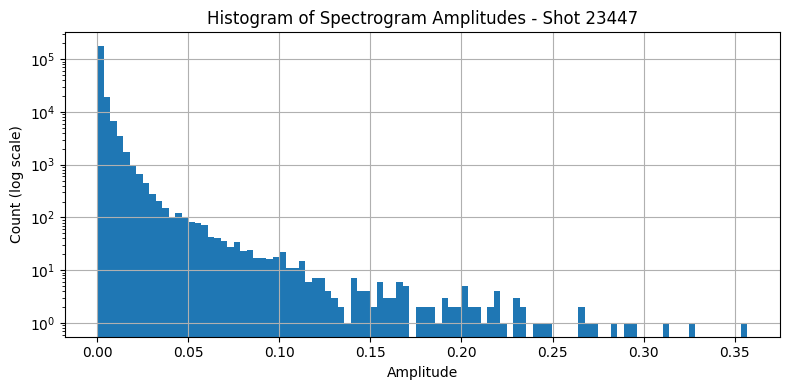

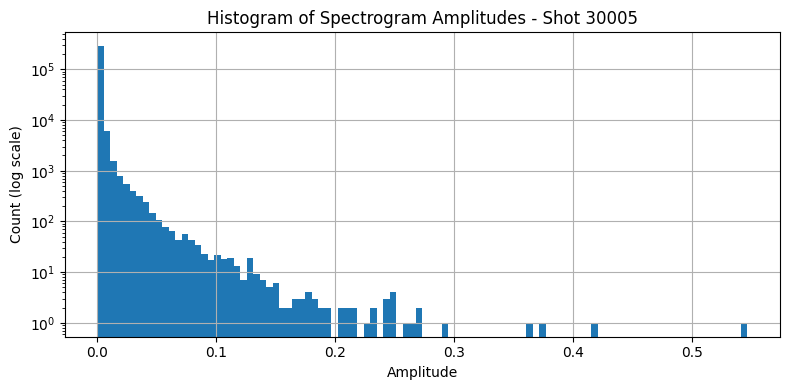

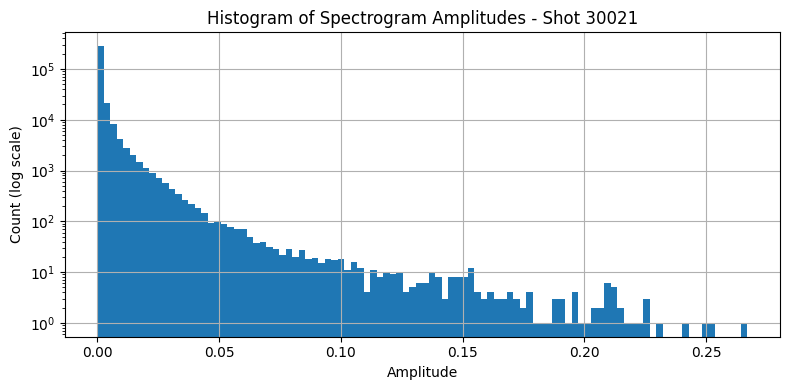

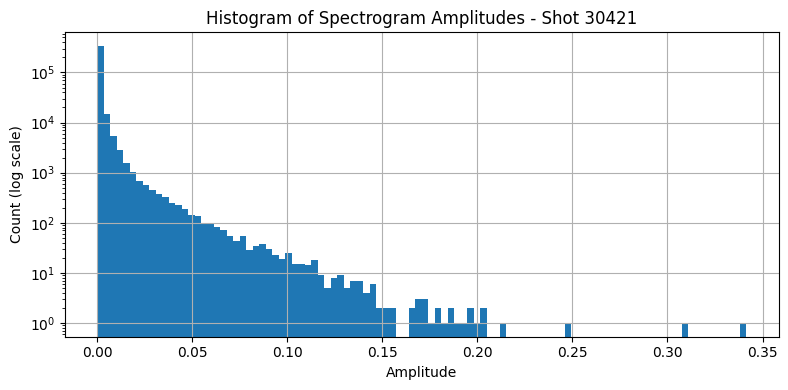

In [55]:
f_list, t_list, Zxx_list =  [], [], []
for i, ds in enumerate(ds_list):
    f, t, Zxx = plot_stft_histogram(ds_list[i], shot_ids[i])
    f_list.append(f)
    t_list.append(t)
    Zxx_list.append(Zxx)

# Ridge detection
## track dominant frequencies over time of Zxx
Find the most prominent modes (like chirping MHD modes) in the plasma.

* We compute the absolute amplitude of Zxx, then for each time slice (Zxx[:, t]), we find the index of the maximum amplitude, and map that back to a frequency using f. The x value in FFT shows a time slice.
* `max_ridges` determines the number of max value of ridges to find. So `max_ridges=2`, picks the top 2 frequencies for each time bin by sorting Zxx amplitudes. 

In [56]:
def plot_stft_ridge(
    t,
    f,
    Zxx,
    shot_id=None,
    threshold=1e-3,
    max_ridges=1,
    fmax_kHz=50,
    smooth=True,
    smooth_window=3,
    return_ridges=False,
    min_bin_distance=2
):
    """
    Extract and plot top-N ridges in STFT with better control.
    Prevents overlap and handles low-power regions.
    """
    fmax = fmax_kHz * 1000
    valid_freq_idx = f <= fmax
    f = f[valid_freq_idx]
    Zxx = Zxx[valid_freq_idx, :]

    magnitude = np.abs(Zxx)
    time_bins = magnitude.shape[1]
    freq_bins = magnitude.shape[0]

    # Set low amplitudes to zero
    magnitude[magnitude < threshold] = 0

    ridge_list = []

    used_mask = np.zeros_like(magnitude, dtype=bool)

    plt.figure(figsize=(10, 4))

    for r in range(max_ridges):
        ridge_freq = np.full(time_bins, np.nan)

        for t_idx in range(time_bins):
            # Get amplitudes for this time bin
            col = magnitude[:, t_idx].copy()

            # Mask already used indices (avoid overlapping ridges)
            col[used_mask[:, t_idx]] = 0

            if col.max() >= threshold:
                i = np.argmax(col)
                ridge_freq[t_idx] = f[i] / 1000  # to kHz

                # Mark this bin and neighboring bins as used
                i_start = max(0, i - min_bin_distance)
                i_end = min(freq_bins, i + min_bin_distance + 1)
                used_mask[i_start:i_end, t_idx] = True

        if smooth:
            filled = np.nan_to_num(ridge_freq, nan=0.0)
            smoothed = uniform_filter1d(filled, size=smooth_window)
            ridge_freq = np.where(np.isnan(ridge_freq), np.nan, smoothed)

        plt.plot(t, ridge_freq, label=f'Ridge {r+1}', lw=2)
        ridge_list.append(ridge_freq)

    plt.xlabel("Time [sec]")
    plt.ylabel("Frequency [kHz]")
    title = "STFT Ridge Detection"
    if shot_id is not None:
        title += f" – Shot {shot_id}"
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    if return_ridges:
        return ridge_list


[None, None, None, None]

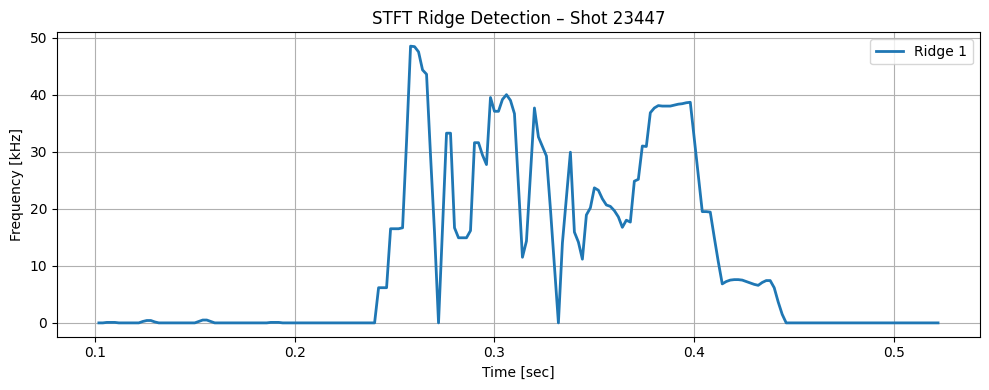

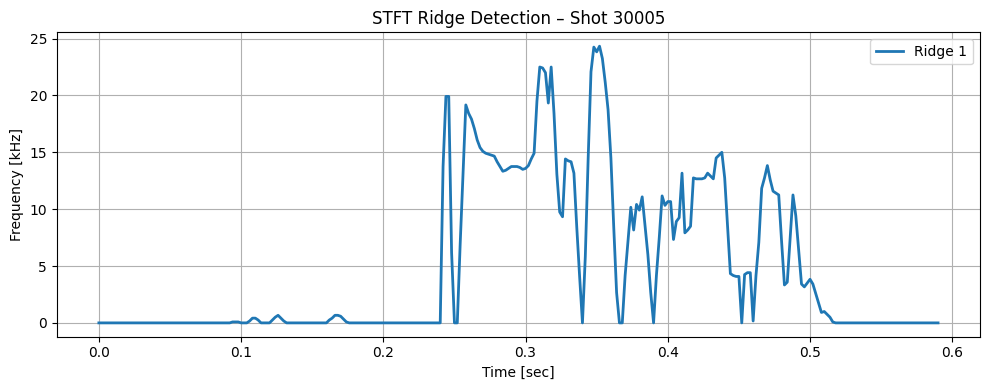

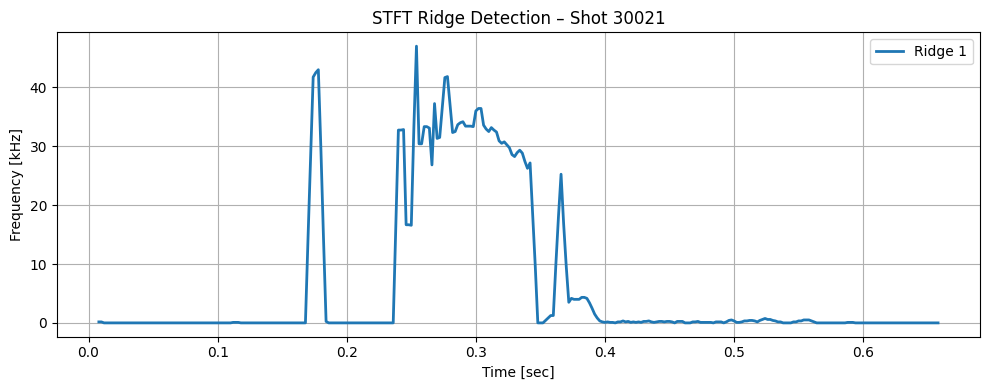

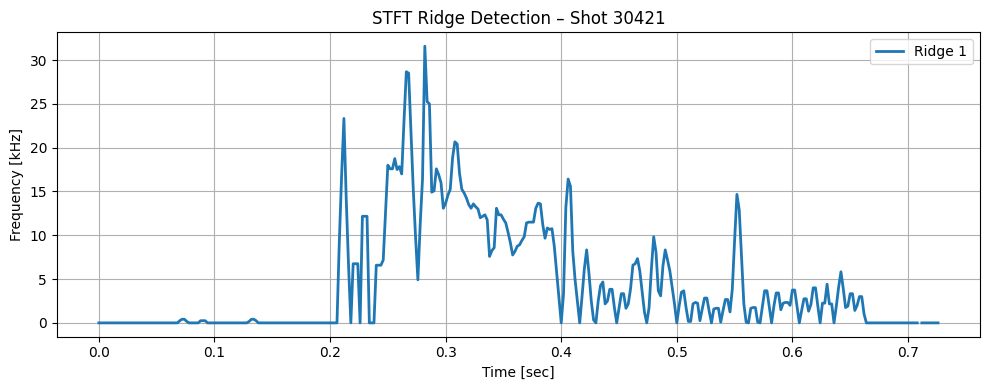

In [57]:
[plot_stft_ridge(
    t_list[i],
    f_list[i],
    Zxx_list[i],
    shot_id=shot_ids[i],
    threshold=1e-3,
    max_ridges=1,
    fmax_kHz=50,
    smooth=True
) for i in range(len(ds_list))]


[None, None, None, None]

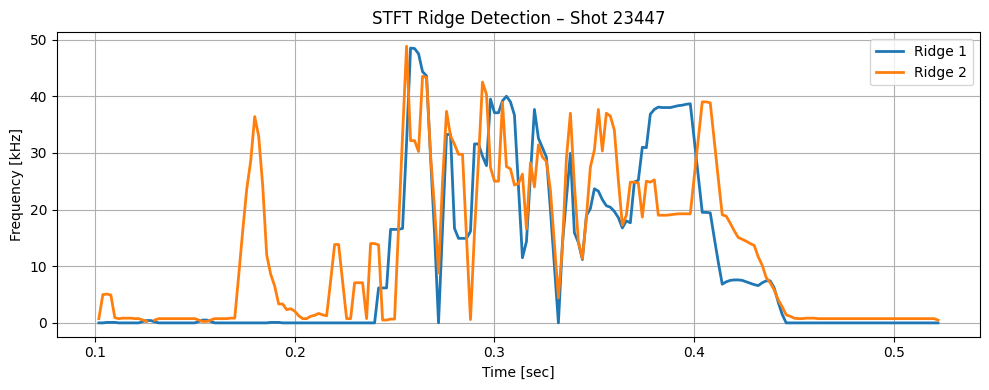

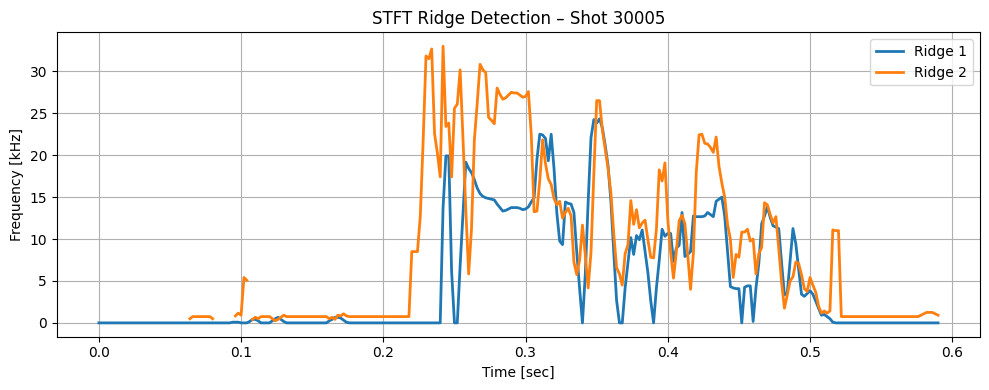

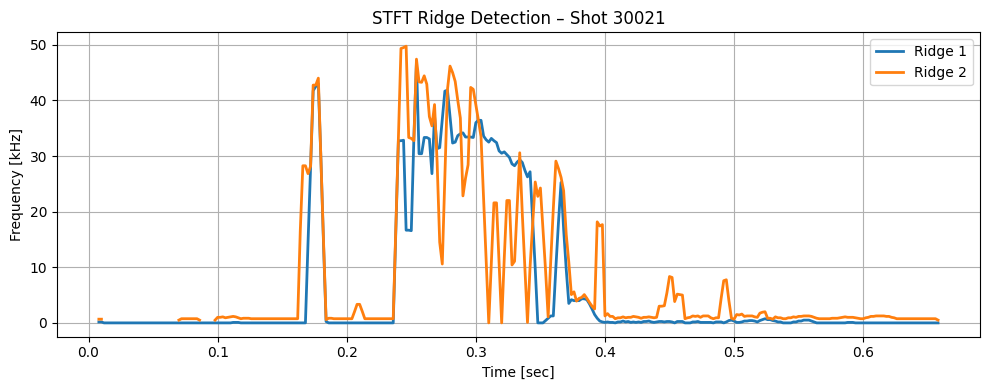

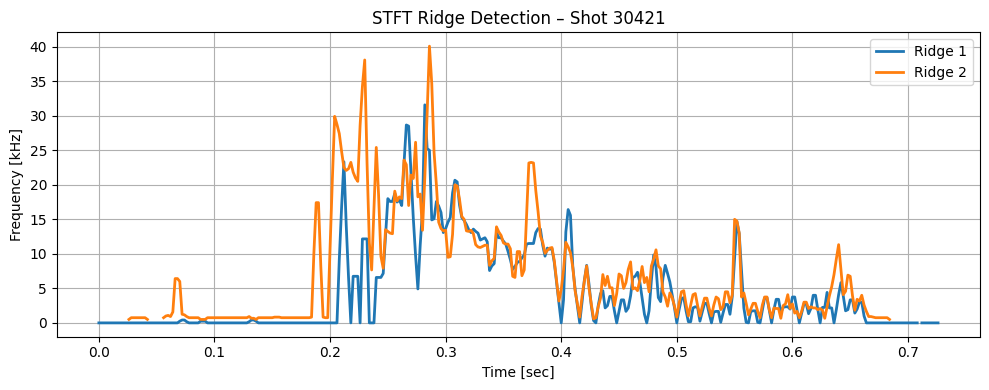

In [58]:
[plot_stft_ridge(
    t_list[i],
    f_list[i],
    Zxx_list[i],
    shot_id=shot_ids[i],
    threshold=1e-3,
    max_ridges=2,
    fmax_kHz=50,
    smooth=True
) for i in range(len(ds_list))]


In [61]:
def plot_spectrogram_with_ridges(t, f, Zxx, ridge_freqs_kHz, shot_id=None, vmin=1e-5, fmax_kHz=50):
    """
    Plot the STFT spectrogram with overlayed ridge tracks.
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm

    fig, ax = plt.subplots(figsize=(12, 5))
    f_kHz = f / 1000

    cax = ax.pcolormesh(t, f_kHz, np.abs(Zxx), shading='nearest',
                        norm=LogNorm(vmin=vmin), cmap='jet')

    # Custom color cycle
    ridge_colors = ['black', 'c', 'magenta', 'lime', 'orange']

    for i, ridge in enumerate(ridge_freqs_kHz):
        color = ridge_colors[i % len(ridge_colors)]
        ax.plot(t, ridge, label=f'Ridge {i+1}', lw=2, color=color)

    ax.set_ylim(0, fmax_kHz)
    ax.set_xlim(0.1, t[-1])
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Frequency [kHz]')
    title = "STFT Spectrogram with Ridge Overlay"
    if shot_id is not None:
        title += f" – Shot {shot_id}"
    ax.set_title(title)
    plt.colorbar(cax, ax=ax, label="Amplitude")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()

/tmp/ipykernel_1087196/2863097040.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


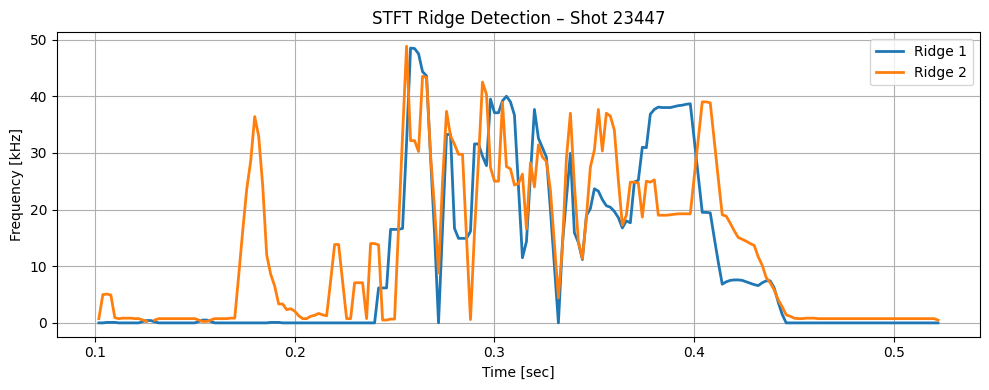

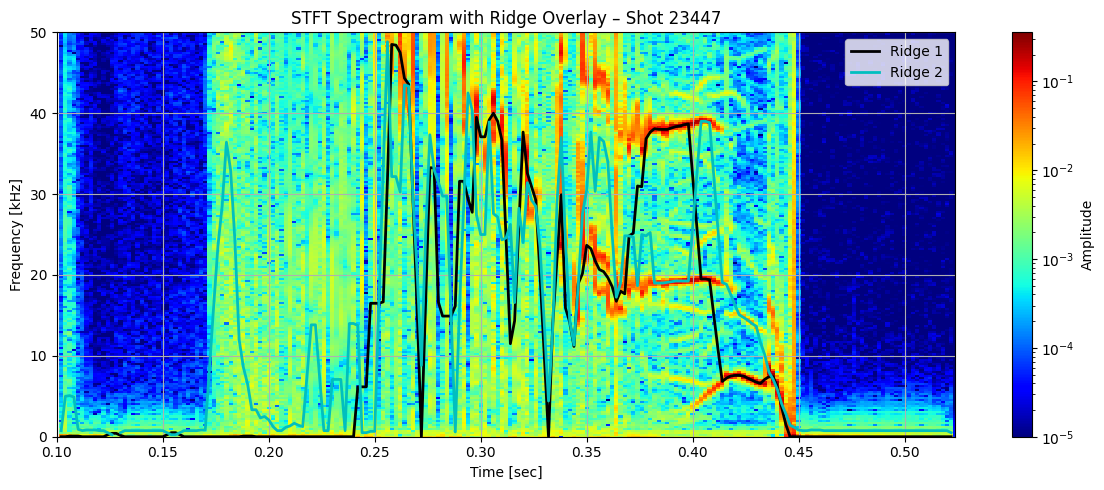

In [62]:
ridges = plot_stft_ridge(
    t_list[0],
    f_list[0],
    Zxx_list[0],
    shot_id=shot_ids[0],
    threshold=1e-3,
    max_ridges=2,
    fmax_kHz=50,
    smooth=True,
    return_ridges=True
)

# Then overlay them:
plot_spectrogram_with_ridges(t_list[0], f_list[0], Zxx_list[0], ridge_freqs_kHz=ridges, shot_id=shot_ids[0])


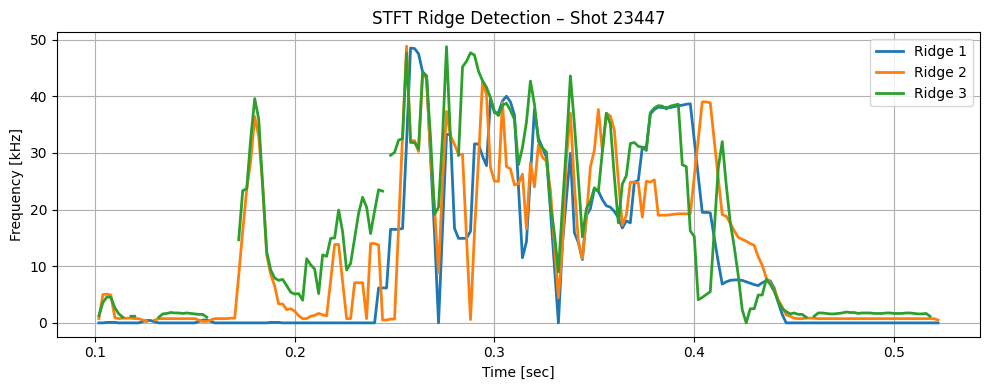

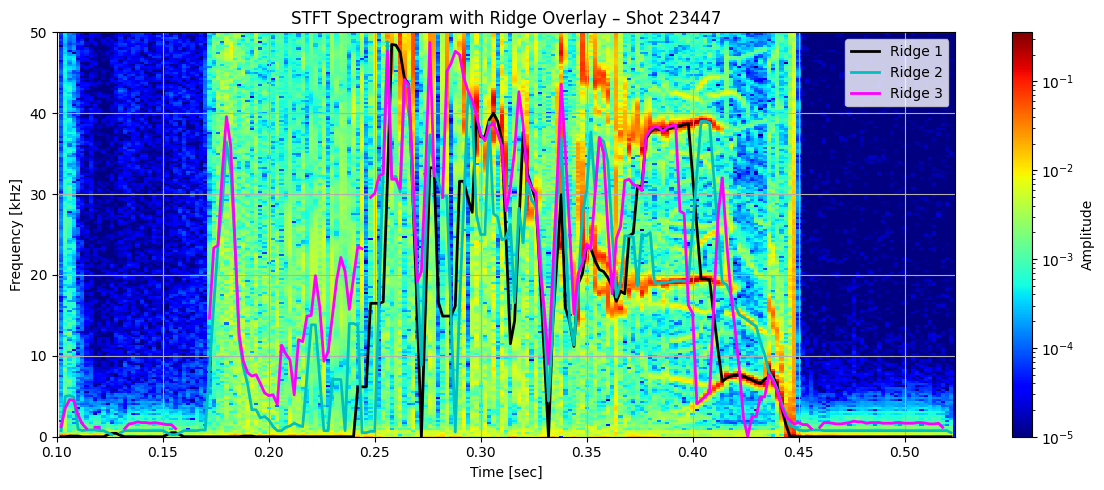

In [63]:
ridges = plot_stft_ridge(
    t_list[0],
    f_list[0],
    Zxx_list[0],
    shot_id=shot_ids[0],
    threshold=1e-3,
    max_ridges=3,
    fmax_kHz=50,
    smooth=True,
    return_ridges=True
)

# Then overlay them:
plot_spectrogram_with_ridges(t_list[0], f_list[0], Zxx_list[0], ridge_freqs_kHz=ridges, shot_id=shot_ids[0])
